# NLP Information Retrieval System for Trip Advisor: Data Analysis and System Creation
Using the scraped data from Trip Advisor, we will develop an Information Retrieval System. This system aims to offer travel recommendations tailored to the unique preferences of individual users.

Our approach involves employing numerous NLP techniques including TD-IDF Vectorization, Count Vectorization, Cosine Similarity, Bi-Grams, Ensemble learning, and BERT. These methods allow the system to extract meaningful patterns, relationships, and context from the wealth of textual data, ensuring a nuanced understanding of user preferences.

As users interact with the recommender system, it dynamically adapts and learns from their choices, continuously refining its recommendations. The goal is to provide a personalized travel experience, capturing the diverse spectrum of travel desires, whether it's the tranquility of a secluded retreat or the vibrancy of a bustling city.

This project represents a step toward creating an intelligent platform that tailors travel suggestions based on insights from Trip Advisor data. The vision is to enhance the travel experience by offering recommendations aligned with users' unique tastes and preferences, contributing to a more personalized approach to travel guidance.

## Table of Contents
---
- [Reading Data](#Reading-Data)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
  - [Word Clouds](#Word-Clouds)
  - [Most Frequent Words](#Most-Frequent-Words)
- [Model Preparation](#Model-Preparation)
  - [Establishing a Baseline](#Establishing-a-Baseline)
- [Modeling Vectorization Methods](#Modeling-Vectorization-Methods)
  - [TF-IDF Vectorization](#TF-IDF-Vectorization)
  - [Count Vectorization](#Count-Vectorization)
  - [Unigrams and Bi-Grams](#Unigrams-and-Bi-Grams)
  - [Model Comparison](#Model-Comparison)
- [Preliminary NLP Recommender Systems](#Preliminary-NLP-Recommender-Systems)
  - [Cosine Similarity using TD-IDF Vectorization](#Cosine-Similarity-using-TD-IDF-Vectorization)
  - [Cosine Similarity using Count Vectorization](#Cosine-Similarity-using-Count-Vectorization)
  - [Our Preliminary Model](#Our-Preliminary-Model)
- [Algorithm Comparison](#Preliminary-NLP-Recommender-Systems)
- [BERT](#BERT)
- [Zero/One/Few Shot Classification](#Zero/One/Few-Shot-Classification)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Reading Data

We first import the necessary libraries for data cleaning, modeling, and visualization.

In [ ]:
%%capture
!pip install nltk
!pip download spacy
!pip install prettytable
!pip install tensorflow-text==2.12.0
!pip install tensorflow==2.12.0 tensorflow-hub==0.12.0
!pip install xgboost
!pip install wordcloud

In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)
sns.palplot(sns.color_palette())
import plotly.graph_objects as go
import plotly.express as px
from prettytable import PrettyTable

import re
import string
import time
import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Download stopwords from nltk
nltk.download('stopwords')

# Download the punkt tokenizer
nltk.download('punkt')

# Download the WordNet resource
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

# For Algorithm Comparison
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb

# For word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For BERT
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import tensorflow_text
import sklearn.metrics as metrics

# For Neural Network
from keras import layers, models, optimizers, losses, metrics
from keras.callbacks import Callback, EarlyStopping

# For Transformers
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

We then summarize what we found from scraping Trip Advisor.

In [ ]:
url = 'https://raw.githubusercontent.com/matthewshawnkehoe/Machine-Learning-in-Python/main/NLP_Recommender_System/Data/all_things_to_do.csv'
travel_df = pd.read_csv(url)
print('There are {} rows and {} columns in our dataset.'.format(travel_df.shape[0],travel_df.shape[1]))

There are 56109 rows and 2 columns in our dataset.


In [ ]:
travel_df.sample(10)

Text                Location
533       Prague Local Experience  Prague, Czech Republic
16365              Place Baudoyer           Paris, France
23133            Dungky Bali Tour         Bali, Indonesia
24717                Kids Kingdom         Bali, Indonesia
29958           Italian Splendour             Rome, Italy
12718          Las Vegas Monorail       Las Vegas, Nevada
15292               Big Bus Paris           Paris, France
4024        Manek Chowk - Udaipur        Rajasthan, India
26176  Tuk Tuk Sightseeing -Tours  Amsterdam, Netherlands
42169        Archer Roof Painting      Sydney, Austrailia

In [ ]:
travel_df.describe()

Text      Location
count             56109         56109
unique            52745            30
top     Statue of Peace  Tokyo, Japan
freq                 68          3180

We are can that there are `52,745` unique things to do at `30` locations. We will now clean our travel dataset.

## Data Cleaning
Let's first check for null values.

In [ ]:
travel_df.isna().sum()

Text        0
Location    0
dtype: int64

There aren't any null values (as we scrapped valid destinations from Trip Advisor). However, we can see that there are a fair amount of locations with duplicated text. We will remove these.

In [ ]:
travel_df = travel_df.drop_duplicates()

We then plot the associated locations to see how many things to do we found at individual locations.

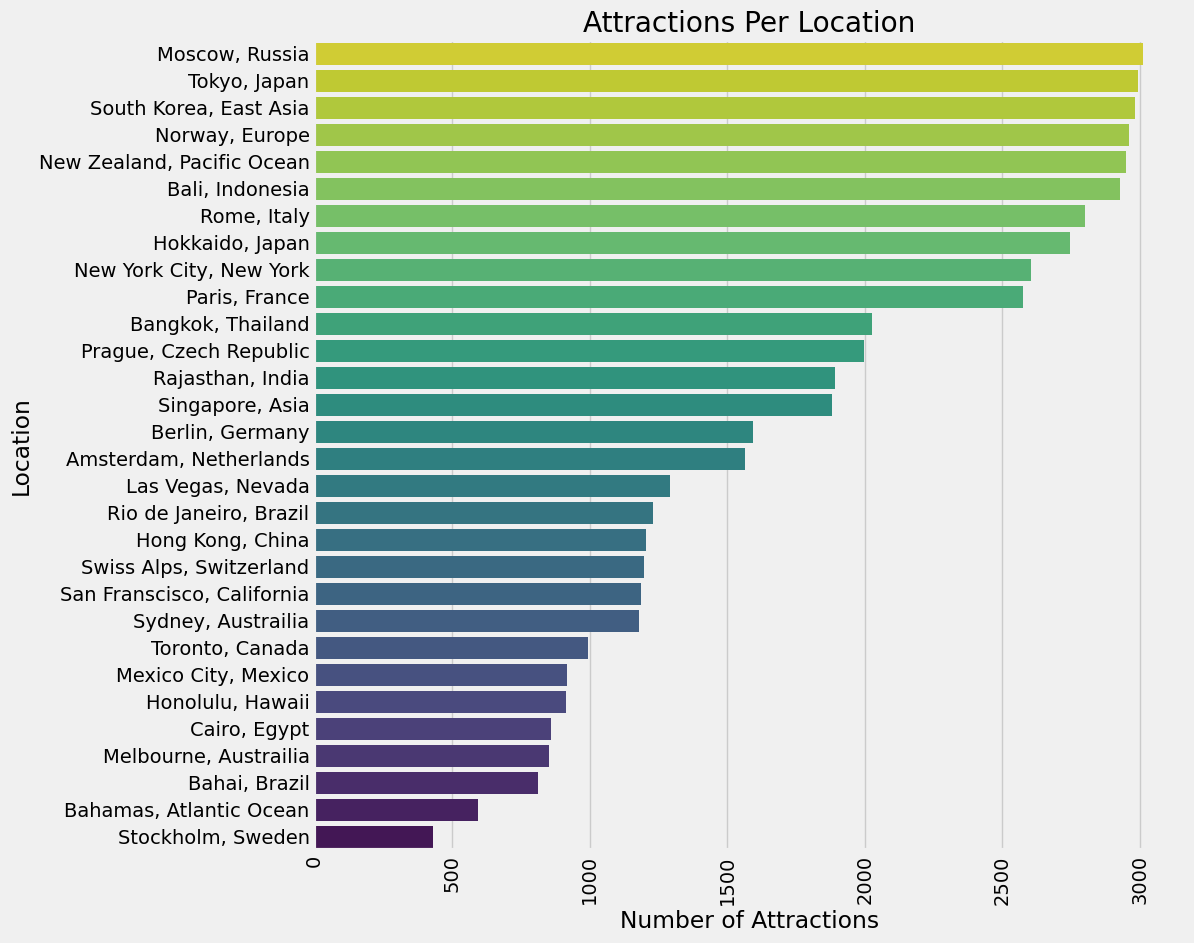

In [ ]:
def plot_things_to_do_per_location(travel_df):
    """
    Plot the number of things to do per location using a bar chart.

    Parameters:
    - travel_df (pd.DataFrame): DataFrame containing the travel data.

    Returns:
    None
    """
    # Group by 'Location' and count occurrences
    locations = travel_df.groupby('Location').count()

    # Create a bar plot
    plt.figure(figsize=(10, 10))

    # Sort the locations by the number of text in descending order
    sorted_cities = locations.sort_values(by='Text', ascending=False)

    # Automatically generate a color palette based on the number of unique locations
    num_locations = len(sorted_cities)
    palette = sns.color_palette('viridis', num_locations)

    # Use seaborn barplot with the automatically generated color palette
    sns.barplot(x='Text', y='Location', data=sorted_cities, palette=palette, hue='Text', dodge=False, legend=False)

    # Set plot title and customize axis labels
    plt.title('Attractions Per Location')
    plt.xlabel('Number of Attractions')
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()


plot_things_to_do_per_location(travel_df)


Next, we will clean the text in things to do for downstream processing.

In [ ]:
def clean_text_column(df, column_name):
    """
    Clean the specified text column in the DataFrame using NLTK for tokenization,
    stopword removal, lemmatization, and punctuation removal.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the text column.
    - column_name (str): Name of the text column to be cleaned.

    Returns:
    None
    """
    # Ensure the specified column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Define NLTK objects for stop words and lemmatization
    stop_words_ = set(stopwords.words('english'))
    wn = WordNetLemmatizer()

    def black_txt(token):
        # Check if the token is not a stop word, not a punctuation, and has a length greater than 2
        return token not in stop_words_ and token not in list(string.punctuation) and len(token) > 2

    def clean_txt(text):
        # Remove apostrophes, digits, non-word characters, and replace 'nbsp'
        text = re.sub("'", "", text)
        text = re.sub("(\\d|\\W)+", " ", text)
        text = text.replace("nbsp", "")

        # Tokenize, lemmatize, and filter based on defined conditions
        clean_text = [wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]

        return " ".join(clean_text)

    # Apply the cleaning function to the specified column
    df[column_name] = df[column_name].apply(clean_txt)

# Apply the clean text function to the "Things to Do"
clean_text_column(travel_df, 'Text')

We now investigate visualizing our travel data.

## Data Visualization
Since our travel locations have thousands of words, let's make word clouds to display common text associated with travel.

### Word Clouds
Below, we create a function for generating word clouds from the raw text scraped by all the travel destinations.

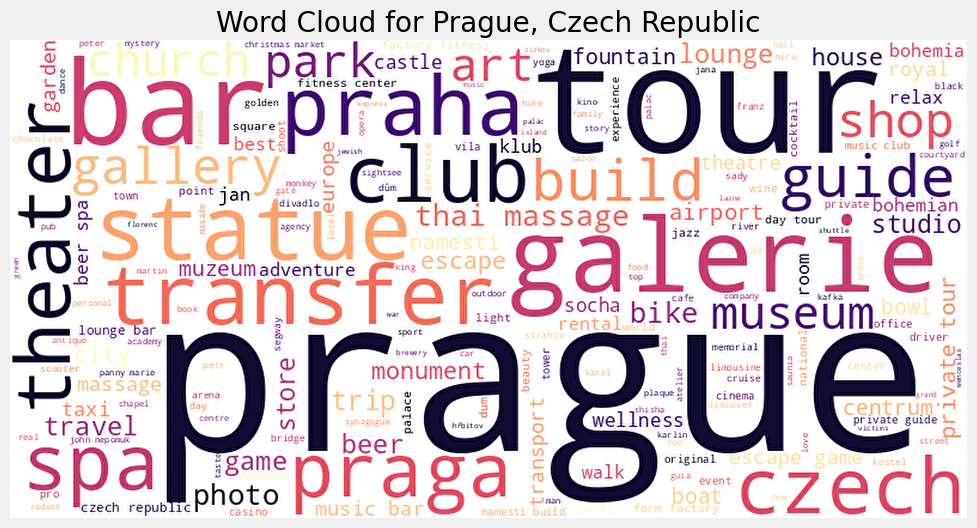

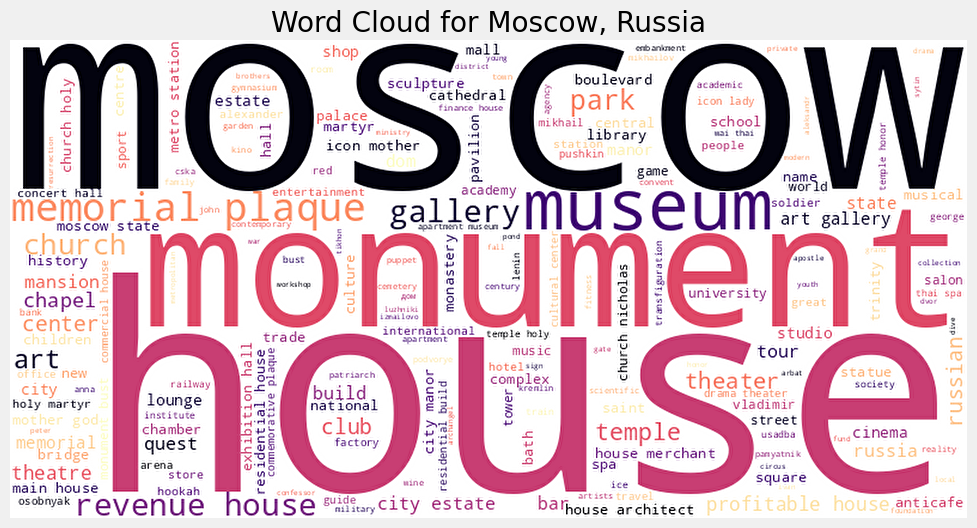

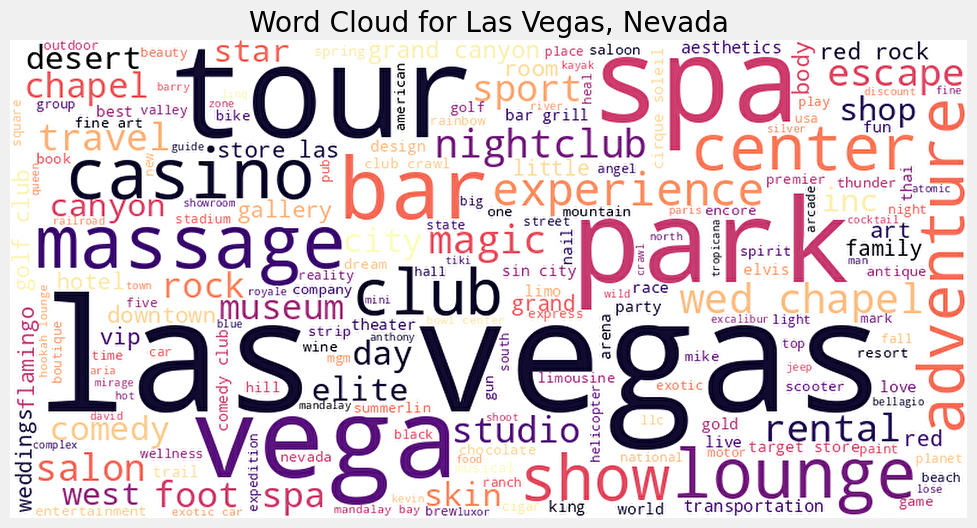

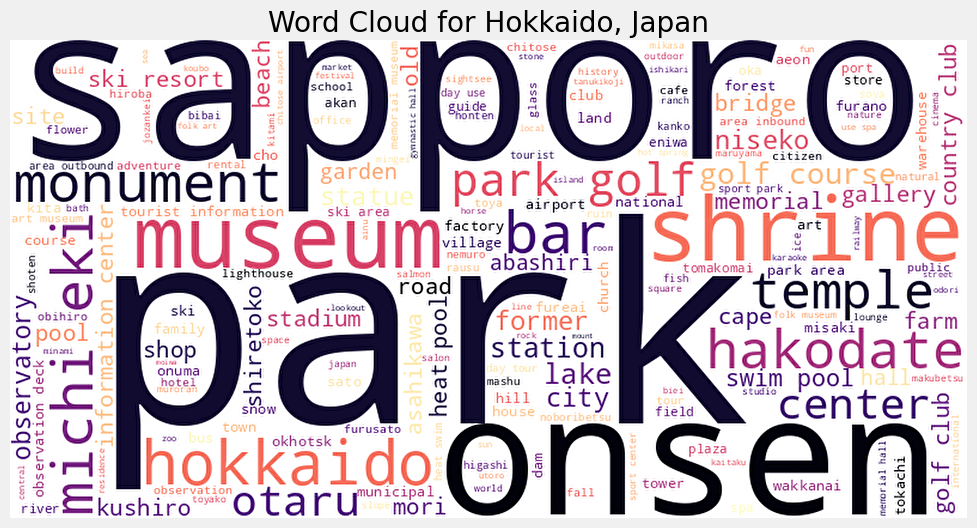

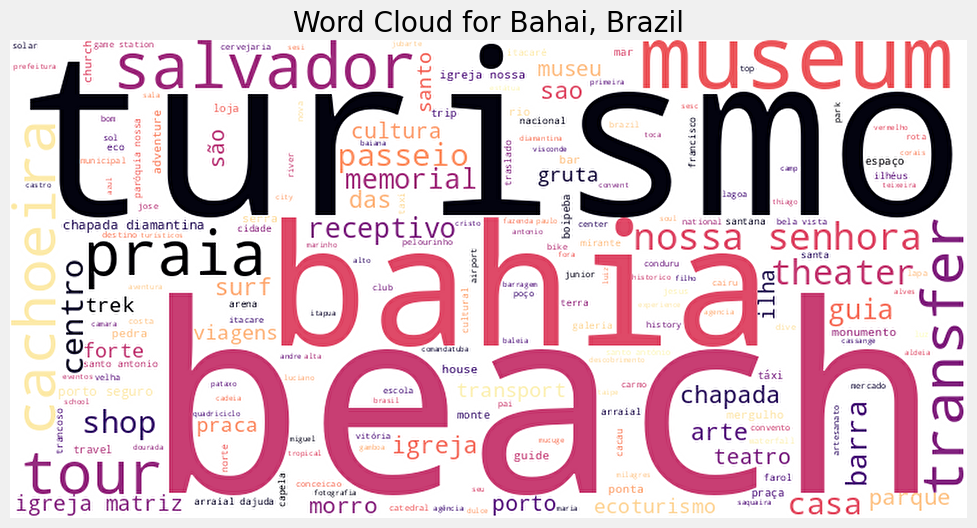

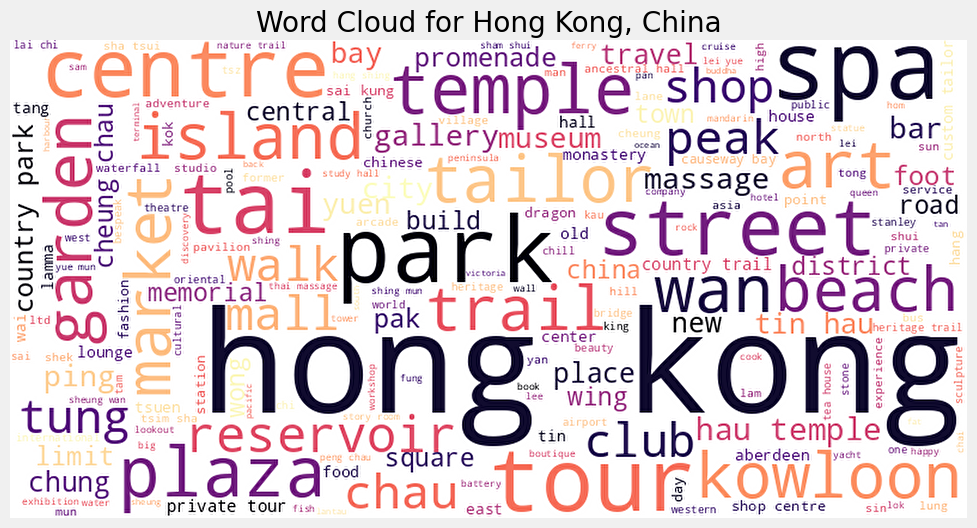

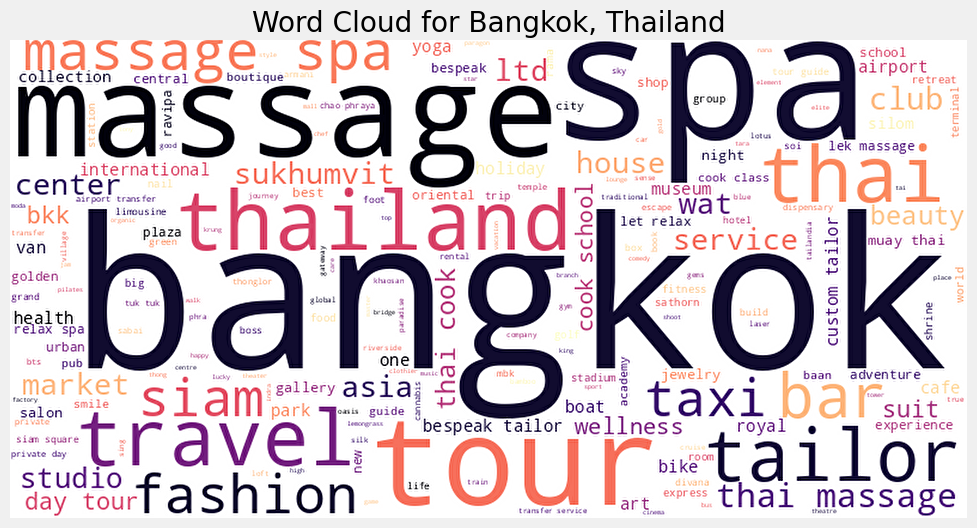

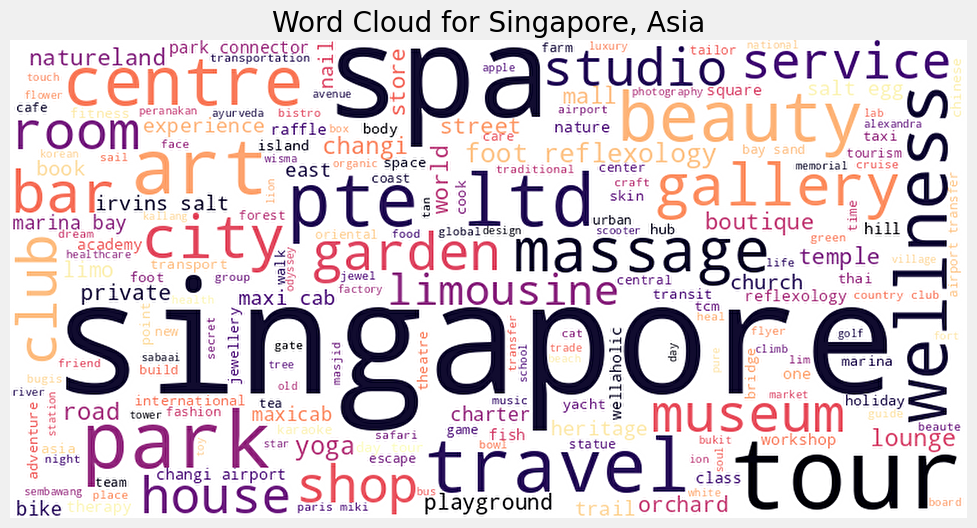

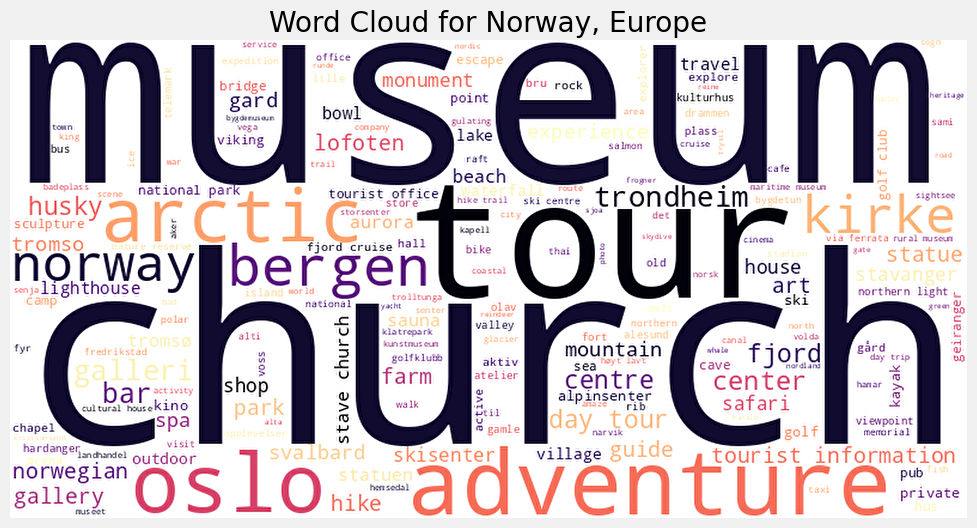

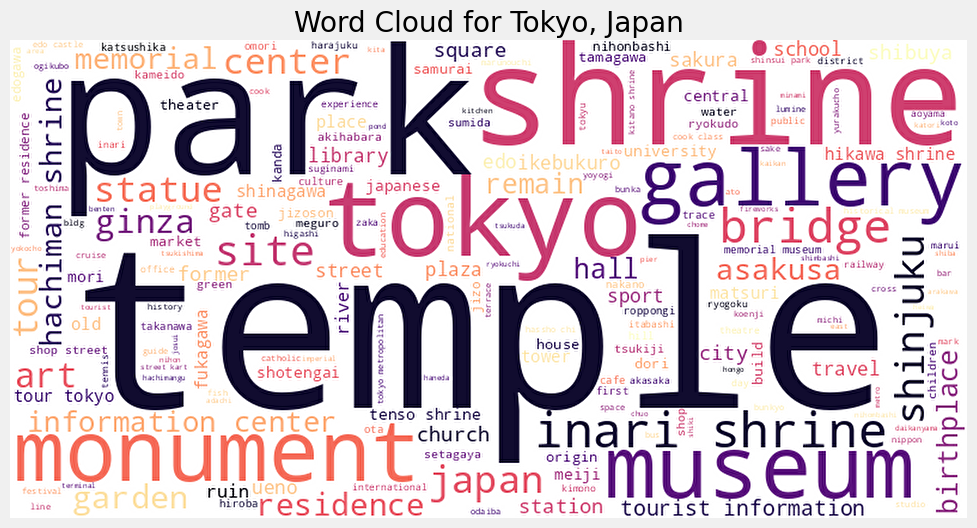

In [ ]:
def generate_wordcloud(data, location):
    """
    Generate and display a word cloud for a specific location in the given data.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the travel data.
    - location (str): Name of the location for which to generate the word cloud.

    Returns:
    None
    """
    # Extract text data for the specified location
    location_text = " ".join(text for text in data[data['Location'] == location]['Text'])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="magma", random_state=42).generate(location_text)

    # Plot the word cloud
    plt.figure(figsize=[11, 11])
    plt.title(f"Word Cloud for {location}")
    plt.imshow(wordcloud, interpolation="sinc")
    plt.axis("off")
    plt.show()
    plt.close()

# Loop through unique locations in the 'Location' column of travel_df with a step of 3
for i in range(0, len(travel_df['Location'].unique()), 3):
    # Get the current location
    location = travel_df['Location'].unique()[i]

    # Call generate_wordcloud function for the current location
    generate_wordcloud(travel_df, location)

    # Print two empty lines
    print("\n\n")

### Most Frequent Words
Next, we analyze the most frequent words in things to do across all locations scraped from Trip Advisor.

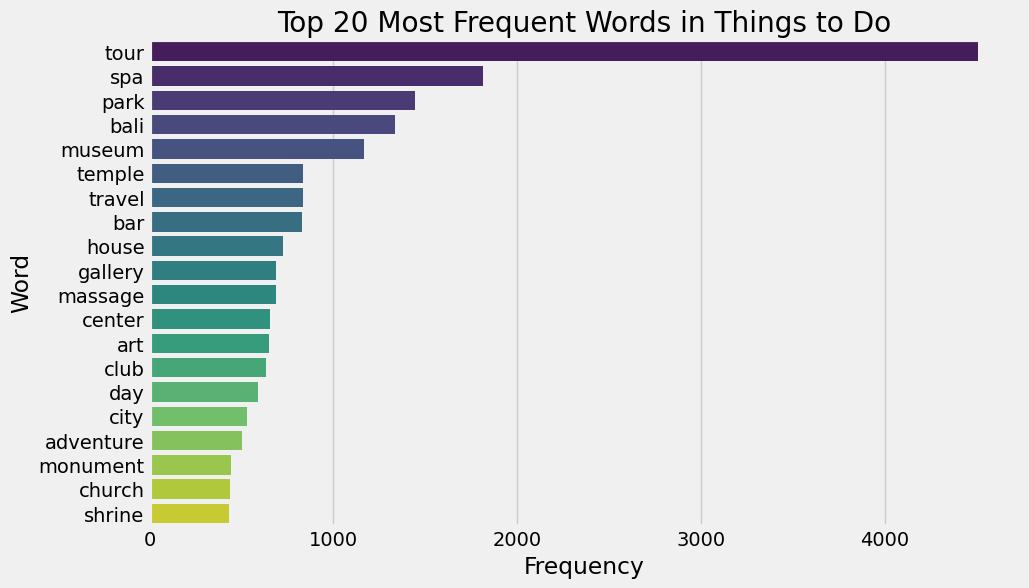

In [ ]:
def plot_most_frequent_words(dataframe, column_name, num_words=10):
    """
    Find the most frequent words in a text column of a DataFrame and plot them in a Seaborn barplot.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the text column.
    - column_name (str): The name of the text column.
    - num_words (int): Number of most frequent words to display. Default is 10.

    Returns:
    None
    """
    # Combine all text in the specified column
    all_text = ' '.join(dataframe[column_name].dropna().astype(str))

    # Tokenize the text
    tokens = word_tokenize(all_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # Calculate frequency distribution
    freq_dist = FreqDist(tokens)

    # Get the top N most frequent words and their frequencies
    top_words, frequencies = zip(*freq_dist.most_common(num_words))

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({'Word': top_words, 'Frequency': frequencies})

    # Plot using Seaborn barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=plot_data, palette='viridis', hue='Word', dodge=False, legend=False)
    plt.title(f"Top {num_words} Most Frequent Words in Things to Do")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()


plot_most_frequent_words(travel_df, 'Text', num_words=20)

We can see that `tour`, `spa`, `park`, `bali`, and `museum` are the five most frequent words. This makes sense as these five words are common activities associated with travel.

## Naive Bayes Classifier

The Naive Bayes classifier is a probabilistic model based on Bayes' Theorem,
used for classification tasks. It assumes that features are conditionally
independent given the class label, making it "naive".

### Bayes' Theorem

Bayes' Theorem describes the probability of a class $y$ given a set of features $X$:

$$
P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}
$$

where
- $ P(y|X) $ is the **posterior probability** of class $ y $ given features $ X $.
- $ P(X|y) $ is the **likelihood** of features $ X $ given class $ y $.
- $ P(y) $ is the **prior probability** of class $ y $.
- $ P(X) $ is the **prior probability** of features $ X $.

### Naive Assumption

The Naive Bayes classifier assumes that all features are conditionally independent given the class label $ y $:

$$
P(X|y) = P(x_1|y) \cdot P(x_2|y) \cdots P(x_n|y)
$$

Where $ X = \{x_1, x_2, \ldots, x_n\} $ are the individual features in the feature vector $ X $. This simplification allows the model to compute the posterior probability efficiently by multiplying the probabilities of each feature independently.

### Types of Naive Bayes Classifiers

1. **Gaussian Naive Bayes**: Assumes continuous features follow a Gaussian distribution.
2. **Multinomial Naive Bayes**: Used for discrete data, such as word counts.
3. **Bernoulli Naive Bayes**: Assumes binary features (0 or 1).

## Model Preparation

Before we start model preparation, we will first establish a baseline.

### Establing a baseline

In our case, the baseline will be a [Naive Bayes estimator](https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf) which is a recommended estimator for text classification problems with large datasets. We first split up our dataset into Train and Test.

In [ ]:
X = travel_df['Text']
y = travel_df['Location']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
X_train.shape, X_test.shape

((39873,), (13291,))

We then create several helper functions to summarize statistical information about our models.

In [ ]:
def compute_sample_weights(y):
    """
    Compute sample weights based on class weights for handling class imbalance.

    Parameters:
    - y (array-like): Target labels.

    Returns:
    - array-like: Sample weights.
    """
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = compute_sample_weight(class_weight={cls: weight for cls, weight in zip(np.unique(y), class_weights)}, y=y)
    return sample_weights

def evaluate_model(model, X, y, label='Training'):
    """
    Evaluate a model on given data and print accuracy, precision, recall, F1-score, and classification report.

    Parameters:
    - model: Trained model.
    - X (array-like): Data.
    - y (array-like): Target labels.
    - label (str): Label for printing.

    Returns:
    None
    """
    y_preds = model.predict(X)
    print(f'------------- {label} Statistics -------------')
    print(f'{label} Accuracy: {accuracy_score(y, y_preds)}')
    print(f'{label} Precision: {precision_score(y, y_preds, average="weighted")}')
    print(f'{label} Recall: {recall_score(y, y_preds, average="weighted")}')
    print(f'{label} F1: {f1_score(y, y_preds, average="weighted")}')
    print()

In [ ]:
def train_and_evaluate_multinomial_model(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    None
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    sample_weights_train = compute_sample_weights(y_train)
    sample_weights_test = compute_sample_weights(y_test)

    model = MultinomialNB()
    model.fit(X_train_baseline, y_train, sample_weights_train)

    evaluate_model(model, X_train_baseline, y_train, label='Training')
    evaluate_model(model, X_test_baseline, y_test, label='Test')

We then test our Naive Bayes Multinomial model.

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.7792741955709377
Training Precision: 0.8055163152916796
Training Recall: 0.7792741955709377
Training F1: 0.7835970511834606

------------- Test Statistics -------------
Test Accuracy: 0.48009931532616057
Test Precision: 0.5562963927081624
Test Recall: 0.48009931532616057
Test F1: 0.4941736109514164



We can improve our baseline model by recognizing that we have class imbalances (due to scraping more text from specific locations in Trip Advisor). Instead of using [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html), we can apply [Complement Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB). Complement Naive Bayes is an adaptation of Multinomial Naive Bayes where the complement of each class is used to calculate the model weights. So, it is suitable for imbalanced data sets and often outperforms the Multinomial Naive Bayes on text classification tasks.

In [ ]:
def train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    None
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    model = ComplementNB()
    model.fit(X_train_baseline, y_train)

    evaluate_model(model, X_train_baseline, y_train, label='Training')
    evaluate_model(model, X_test_baseline, y_test, label='Test')

Let's test our improved model with the Complement Naive Bayes.

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.8703132445514509
Training Precision: 0.8723160691357223
Training Recall: 0.8703132445514509
Training F1: 0.8695983622251657

------------- Test Statistics -------------
Test Accuracy: 0.5119253630276127
Test Precision: 0.5541536160043723
Test Recall: 0.5119253630276127
Test F1: 0.5179273194760169



We see that we get reasonable performance results with the Complement Naive Bayes algorithm. Can we get better performance results with a different algorithm?

## Modeling Vectorization Methods

**TF-IDF Vectorization vs. Count Vectorization:** Count Vectorization counts how many times each word appears in the text, creating a matrix where each entry is the frequency of a word.  On the other hand, TF-IDF Vectorization goes a step further by not only counting word frequencies but also giving less weight to common words and more weight to unique words, making it easier to identify the most important words in a document. Therefore, one often finds better performance through TF-IDF Vectorization.

### Count Vectorization

As a first comparison, we will analyze performance results using Count Vectorization instead of TD-IDF Vectorization.

In [ ]:
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore')
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.851854638477165
Training Precision: 0.854283563482534
Training Recall: 0.851854638477165
Training F1: 0.8509377332188205

------------- Test Statistics -------------
Test Accuracy: 0.5125272740952524
Test Precision: 0.5572557367391023
Test Recall: 0.5125272740952524
Test F1: 0.5179923807293196



The performance results are slightly lower than TD-IDF vectorization. Next, we will try Unigrams and Bi-Grams aginst TD-IDF vectorization and Count Vectorization.

### Unigrams and Bi-Grams

Unigrams and Bi-Grams with TD-IDF Vectorization.

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore', ngram_range=(1,2))
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.9626313545506985
Training Precision: 0.9629586947983386
Training Recall: 0.9626313545506985
Training F1: 0.9626191538224839

------------- Test Statistics -------------
Test Accuracy: 0.5203521179745693
Test Precision: 0.5633712234518169
Test Recall: 0.5203521179745693
Test F1: 0.5278212485403018



Unigrams and Bi-Grams with Count Vectorization.

In [ ]:
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore', ngram_range=(1,2))
train_and_evaluate_complement_multinomial_model(X_train, y_train, X_test, y_test, vectorizer)

------------- Training Statistics -------------
Training Accuracy: 0.9519474331000928
Training Precision: 0.9522497475077971
Training Recall: 0.9519474331000928
Training F1: 0.9518948609685237

------------- Test Statistics -------------
Test Accuracy: 0.520954029042209
Test Precision: 0.5660549535093631
Test Recall: 0.520954029042209
Test F1: 0.5281321538948689



We see positive results with setting `ngram_range=(1,2)`, which is both unigrams and bi-grams.

### Model Comparison

We now combine all of our results into a table for comparison.

In [ ]:
def evaluate_model_metrics(model, X, y, label='Training'):
    """
    Evaluate a model on given data and return accuracy, precision, recall, and F1-score.

    Parameters:
    - model: Trained model.
    - X (array-like): Data.
    - y (array-like): Target labels.
    - label (str): Label for printing.

    Returns:
    dict: Dictionary containing evaluation metrics.
    """
    y_preds = model.predict(X)
    metrics = {
        'Accuracy': accuracy_score(y, y_preds),
        'Precision': precision_score(y, y_preds, average='weighted'),
        'Recall': recall_score(y, y_preds, average='weighted'),
        'F1': f1_score(y, y_preds, average='weighted')
    }
    return metrics

def train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer):
    """
    Train and evaluate a Complement Naive Bayes model on the training and testing data.

    Parameters:
    - X_train (array-like): Training text data.
    - y_train (array-like): Training labels.
    - X_test (array-like): Testing text data.
    - y_test (array-like): Testing labels.
    - vectorizer: Text vectorizer.

    Returns:
    PrettyTable: Table containing evaluation results.
    """
    X_train_baseline = vectorizer.fit_transform(X_train)
    X_test_baseline = vectorizer.transform(X_test)

    model = ComplementNB()
    model.fit(X_train_baseline, y_train)

    train_results = evaluate_model_metrics(model, X_train_baseline, y_train, label='Training')
    test_results = evaluate_model_metrics(model, X_test_baseline, y_test, label='Test')

    # Create a PrettyTable
    table = PrettyTable()
    table.field_names = ["Metric", "Training", "Test"]

    # Add rows to the table
    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    for metric in metrics:
        table.add_row([
            metric,
            f"{train_results[metric]:.2%}",
            f"{test_results[metric]:.2%}"
        ])

    return table

# Example usage:
vectorizer1 = TfidfVectorizer(analyzer='word', decode_error='ignore')
result1 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer1)

vectorizer2 = CountVectorizer(analyzer='word', decode_error='ignore')
result2 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer2)

vectorizer3 = TfidfVectorizer(analyzer='word', decode_error='ignore', ngram_range=(1,2))
result3 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer3)

vectorizer4 = CountVectorizer(analyzer='word', decode_error='ignore', ngram_range=(1,2))
result4 = train_and_evaluate_complement_multinomial_table(X_train, y_train, X_test, y_test, vectorizer4)

# Print the tables
print("Vectorizer 1 (TfidfVectorizer):")
print(result1)

print("\nVectorizer 2 (CountVectorizer):")
print(result2)

print("\nVectorizer 3 (TfidfVectorizer, ngram_range=(1,2)):")
print(result3)

print("\nVectorizer 4 (CountVectorizer, ngram_range=(1,2)):")
print(result4)


Vectorizer 1 (TfidfVectorizer):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  87.03%  | 51.19% |
| Precision |  87.23%  | 55.42% |
|   Recall  |  87.03%  | 51.19% |
|     F1    |  86.96%  | 51.79% |
+-----------+----------+--------+

Vectorizer 2 (CountVectorizer):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  85.19%  | 51.25% |
| Precision |  85.43%  | 55.73% |
|   Recall  |  85.19%  | 51.25% |
|     F1    |  85.09%  | 51.80% |
+-----------+----------+--------+

Vectorizer 3 (TfidfVectorizer, ngram_range=(1,2)):
+-----------+----------+--------+
|   Metric  | Training |  Test  |
+-----------+----------+--------+
|  Accuracy |  96.26%  | 52.04% |
| Precision |  96.30%  | 56.34% |
|   Recall  |  96.26%  | 52.04% |
|     F1    |  96.26%  | 52.78% |
+-----------+----------+--------+

Vectorizer 4 (CountVectorizer, ngram_range=(1,2)):
+-----------+--

Our third vectorization method (TD-IDF with unigrams and bi-grams) has the best performance. We see that this technique gives slightly better performance metrics than TD-IDF vectorizaion with the Complement Naive Bayes algorithm.

## Preliminary Retrieval Systems
We now test multiple retrieval systems, such as Cosine Similarity with TD-IDF, Cosine Similarity with Count Vectorization, K-Nearest Neighbors, Logistic Regression, Support Vector Machine, Decision Tree, and Ensemble Learning. This allows us to evaluate their effectiveness in providing accurate and personalized travel recommendations.

### Cosine Similarity

Cosine similarity is a metric used to measure the similarity of two vectors. Specifically, it measures the similarity in the direction or orientation of the vectors ignoring differences in their magnitude or scale. Both vectors need to be part of the same inner product space, meaning they must produce a scalar through inner product multiplication. The similarity of two vectors is measured by the cosine of the angle between them. It ranges from -1 to 1, where 1 means the vectors are identical, 0 means they are orthogonal (no similarity), and -1 means they are exactly opposite. This metric is commonly used in text analysis to compare the similarity of documents by representing them as high-dimensional vectors.

if we have two vectors, $\vec{A}$ and $\vec{B}$, the similarity between them is calculated as:

$$
\text{cosine similarity} = \cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}
$$

where
- $\vec{A} \cdot \vec{B}$ is the dot product of the vectors $\vec{A}$ and $\vec{B}$.
- $\|\vec{A}\|$ and $\|\vec{B}\|$ are the magnitudes (or norms) of the vectors $\vec{A}$ and $\vec{B}$.
- $\theta$ is the angle between the vectors.

### Cosine Similarity using TD-IDF


In [ ]:
text_to_predict = "I want to eat a lot of chocolate and pizza."
vectorizer = TfidfVectorizer(analyzer='word', decode_error='ignore')
X_train_baseline = vectorizer.fit_transform(X_train)
travel_tfidf = vectorizer.transform([text_to_predict])

cos_similarity_tfidf = [cosine_similarity(travel_tfidf, x) for x in X_train_baseline]
cos_similarity_tfidf_list = list(cos_similarity_tfidf)


Create a function to find the top $N$ recommendations by score.

In [ ]:
def get_recommendation(text_to_predict, df_all, scores, top_k=10):
    """
    Generate recommendation DataFrame based on top scores, DataFrame, and text.

    Parameters:
    - text_to_predict (str): The user's input text.
    - df_all (pd.DataFrame): DataFrame containing additional information (e.g., locations).
    - scores (list): List of similarity scores.
    - top_k (int): Number of top recommendations to retrieve (default is 10).

    Returns:
    - pd.DataFrame: DataFrame containing recommendations.
    """
    # Get top-k indices based on scores
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]

    recommendation = pd.DataFrame(columns=['Text', 'Attraction Text', 'Similarity Score', 'Location'])

    for i, index in enumerate(top_indices):
        recommendation.at[i, 'Text'] = text_to_predict
        recommendation.at[i, 'Attraction Text'] = df_all['Text'].iloc[index]
        recommendation.at[i, 'Similarity Score'] = round(scores[index],2)
        recommendation.at[i, 'Location'] = df_all['Location'].iloc[index]

    return recommendation

Test the recommendation function against the travel data.

In [ ]:
# Generate recommendation using the get_recommendation function
list_scores = list_scores = [cos_similarity_tfidf_list[i][0][0] for i in range(len(cos_similarity_tfidf_list))]
recommendation_df = get_recommendation(text_to_predict, travel_df, list_scores)
recommendation_df

Text                Attraction Text  \
0  I want to eat a lot of chocolate and pizza.    centro cultura camilo jesus   
1  I want to eat a lot of chocolate and pizza.  coc kongressorganisation gmbh   
2  I want to eat a lot of chocolate and pizza.                  lavana grande   
3  I want to eat a lot of chocolate and pizza.               java car service   
4  I want to eat a lot of chocolate and pizza.              athenaeum theatre   
5  I want to eat a lot of chocolate and pizza.                       ven bali   
6  I want to eat a lot of chocolate and pizza.            one room fan museum   
7  I want to eat a lot of chocolate and pizza.      firth tower estate museum   
8  I want to eat a lot of chocolate and pizza.    beautiful winery taste room   
9  I want to eat a lot of chocolate and pizza.                      pure boat   

  Similarity Score                    Location  
0             0.47               Bahai, Brazil  
1             0.46             Berlin, Germany  
2             0.44           Bangkok, Thailand  
3             0.41     New York City, New York  
4             0.39       Melbourne, Austrailia  
5             0.38             Bali, Indonesia  
6             0.38  New Zealand, Pacific Ocean  
7             0.37  New Zealand, Pacific Ocean  
8             0.35  New Zealand, Pacific Ocean  
9             0.34      Amsterdam, Netherlands

## Cosine Similarity using Count Vectorizer

In [ ]:
text_to_predict = "I want to eat a lot of chocolate and pizza."
vectorizer = CountVectorizer(analyzer='word', decode_error='ignore')
X_train_baseline = vectorizer.fit_transform(X_train)
travel_count_vectorizer = vectorizer.transform([text_to_predict])

cos_similarity_count_vectorizer = map(lambda x: cosine_similarity(travel_count_vectorizer, x),X_train_baseline)
cos_similarity_count_vectorizer_list = list(cos_similarity_count_vectorizer)

Test the recommendation function against a different form of vectorization.

In [ ]:
# Generate recommendation using the get_recommendation function
list_scores = list_scores = [cos_similarity_count_vectorizer_list[i][0][0] for i in range(len(cos_similarity_count_vectorizer_list))]
recommendation_df = get_recommendation(text_to_predict, travel_df, list_scores)
recommendation_df

Text                Attraction Text  \
0  I want to eat a lot of chocolate and pizza.    centro cultura camilo jesus   
1  I want to eat a lot of chocolate and pizza.                  lavana grande   
2  I want to eat a lot of chocolate and pizza.  coc kongressorganisation gmbh   
3  I want to eat a lot of chocolate and pizza.               massage netranie   
4  I want to eat a lot of chocolate and pizza.               java car service   
5  I want to eat a lot of chocolate and pizza.                  jacques genin   
6  I want to eat a lot of chocolate and pizza.              athenaeum theatre   
7  I want to eat a lot of chocolate and pizza.             mausoleo santelena   
8  I want to eat a lot of chocolate and pizza.                  petchthailand   
9  I want to eat a lot of chocolate and pizza.                       cozy spa   

  Similarity Score                 Location  
0              0.5            Bahai, Brazil  
1              0.5        Bangkok, Thailand  
2             0.35          Berlin, Germany  
3             0.35  New York City, New York  
4             0.35  New York City, New York  
5             0.35            Paris, France  
6             0.35    Melbourne, Austrailia  
7             0.35              Rome, Italy  
8             0.35        Bangkok, Thailand  
9             0.35        Bangkok, Thailand

Both of these have fairly bad performance with a similarity score of `0.5` or lower. Can our best model from the vectorization methods section do any better?

### Our Preliminary Model

We now build a pipeline using the TD-IDF Vectorization and both unigrams and bi-grams and measure its similarity score.

In [ ]:
pipe = Pipeline(steps=[
                ('TFIDFVectorizer', TfidfVectorizer(analyzer='word',decode_error='ignore',ngram_range=(1,2))),
                ('NaiveBayes', MultinomialNB())]
                )

pipe.fit(X_train,y_train)
print("Train similarity score is {}.".format(pipe.score(X_train, y_train)))

Train similarity score is 0.7352343691219623.


Let's test several examples.

In [ ]:
pipe.predict(['I want to go swimming and lay out on the beach.'])[0]

'New Zealand, Pacific Ocean'

In [ ]:
pipe.predict(['I want to go skiing.'])[0]

'Norway, Europe'

In [ ]:
pipe.predict(['Meet lots of people and play sports.'])[0]

'Moscow, Russia'

In [ ]:
pipe.predict(['Stay inside and look at museums.'])[0]

'New York City, New York'

These predictions seem reasonable. However, it appears that we could certainly beat these performance metrics. We will now benchmark several algorithms outside of the typical vectorization and cosine similarity techniques.

## Algorithm Comprison

We first convert `X_train` and `X_test` to Dataframes for processing. We also apply the `ravel` to make `y_train` and `y_test` a 1D array and encode the target variable.

In [ ]:
# Convert to pandas DataFrame
X_train_df = pd.DataFrame(X_train, columns=['Text'])
X_test_df = pd.DataFrame(X_test, columns=['Text'])

# Convert to 1D array
y_train_ar = y_train.ravel()
y_test_ar = y_test.ravel()

# Use OrdinalEncoder to encode the target variable
ordinal_encoder = OrdinalEncoder()
y_train_encoded = ordinal_encoder.fit_transform(y_train_ar.reshape(-1, 1)).reshape(-1)
y_test_encoded = ordinal_encoder.transform(y_test_ar.reshape(-1, 1)).reshape(-1)

We then create a ColumnTransformer for numerical and categorical features.

In [ ]:
# Create a ColumnTransformer for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(analyzer='word',decode_error='ignore',ngram_range=(1,2)), 'Text')
    ])


Let's test several ensemble methods to investigate the performance of different classification algorithms.

In [ ]:
# Three classifiers for ensemble learning
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=30, max_depth=8)
svm = LinearSVC()

classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagging Decision Tree (Ensemble)': BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators=10),
    'Boosting Decision Tree (Ensemble)': AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10, max_depth=4),
                                     n_estimators=10, learning_rate=0.6),
    'Random Forest (Ensemble)': RandomForestClassifier(n_estimators=30, max_depth=8),
    'Voting Classifier (Ensemble)': VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                                                                  ('rf', RandomForestClassifier(n_estimators=30, max_depth=8)),
                                                                  ('svm', LinearSVC())], voting='hard')
}

results = []
for label, clf in classifiers.items():
    start = datetime.datetime.now()
    pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', clf)
    ])
    scores = cross_val_score(pipeline, X_train_df, y_train_ar, scoring='accuracy', cv=5, n_jobs=-1)
    pipeline.fit(X_train_df, y_train_ar)
    cv_time = str(datetime.datetime.now() - start)[:-3]
    result_dict = {
        'Model': label,
        'Train Accuracy': pipeline.score(X_train_df, y_train_ar),
        'Test Accuracy': pipeline.score(X_test_df, y_test_ar),
        'Max CrossVal': scores.max(),
        'Timespan': cv_time
    }
    results.append(result_dict)
    x = list(result_dict.values())

output = pd.DataFrame(results)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likel

In [ ]:
output.sort_values(by= 'Test Accuracy',ascending=False).reset_index(drop=True)

Model  Train Accuracy  Test Accuracy  \
0             Support Vector Machine        0.981642       0.526070   
1       Voting Classifier (Ensemble)        0.853585       0.499812   
2                Logistic Regression        0.770020       0.481905   
3   Bagging Decision Tree (Ensemble)        0.851679       0.396057   
4                      Decision Tree        0.984150       0.371981   
5                                KNN        0.383643       0.213227   
6  Boosting Decision Tree (Ensemble)        0.217666       0.213077   
7           Random Forest (Ensemble)        0.215860       0.202242   

   Max CrossVal     Timespan  
0      0.526520  0:00:07.964  
1      0.507837  0:03:12.144  
2      0.490658  0:03:04.163  
3      0.402382  0:07:06.727  
4      0.379561  0:01:54.020  
5      0.203787  0:00:11.321  
6      0.215047  0:00:08.875  
7      0.215799  0:00:02.332

We can see that Support Vector Machine had the highest accuracy in Training and Test.

In [ ]:
Higher_Test_Accuracy = output.sort_values(by= 'Test Accuracy',ascending= False).Model
Higher_Test_Accuracy

2               Support Vector Machine
7         Voting Classifier (Ensemble)
1                  Logistic Regression
4     Bagging Decision Tree (Ensemble)
3                        Decision Tree
0                                  KNN
5    Boosting Decision Tree (Ensemble)
6             Random Forest (Ensemble)
Name: Model, dtype: object

Also, the Random Forest (Ensemble) method took the least amount of processing time.

In [ ]:
Fastest = output.sort_values(by= 'Timespan').Model
Fastest

6             Random Forest (Ensemble)
2               Support Vector Machine
5    Boosting Decision Tree (Ensemble)
0                                  KNN
3                        Decision Tree
1                  Logistic Regression
7         Voting Classifier (Ensemble)
4     Bagging Decision Tree (Ensemble)
Name: Model, dtype: object

To save time for future analysis, we  save the algorithm comparison analysis to a `.csv` file.

In [ ]:
csv_name = 'algorithm_comparison.csv'
output.to_csv(csv_name, index=False)

We now investigate the performance of BERT (Bidirectional Encoder Representations from Transformers).

### BERT

Any text-based machine learning task requires processing the content and converting it into numbers so the machine can understand it. Since our task  requires the dataset's title, we will perform some data preparation such as reducing characters, deleting special characters, etc. The code below carries out the necessary preprocessing actions.

In [ ]:
url = 'https://raw.githubusercontent.com/matthewshawnkehoe/Machine-Learning-in-Python/main/NLP_Recommender_System/Data/all_things_to_do.csv'
df_all = pd.read_csv(url)
df_all = df_all.drop_duplicates(subset = ['Text'])
df_all = df_all[['Text', 'Location']]
df_all.columns = ['Text', 'Location']
df_all['cleaned_text'] = df_all['Text'].apply(lambda x: x.lower())
df_all['cleaned_text'] = df_all['cleaned_text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))


We will use pretrained BERT embeddings published on Tensorflow Hub to create word embeddings. Here, we preprocess the data by removing stop words and other things using a scaled-down version of `bert_un_cased`. Subsequently, `small_bert` pretrained embeddings are used to generate the corresponding embedding vectors for every title in our dataset. The resulting embedding will contain the output for each token in the sequence as well as the pooled output for the entire sequence/title; however, in this case, we will only be using the pooled outputs because they hold the property of lowering compute power consumption and demonstrating the model's status as an unsupervised learning model.


In [ ]:
# Load the preprocessor and encoder
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

def get_bert_embeddings(text, preprocessor, encoder):
    """
    Get BERT embeddings for a given text using preprocessor and encoder.

    Parameters:
    - text (str): The input text for which embeddings are needed.
    - preprocessor: The preprocessor layer for BERT.
    - encoder: The encoder layer for BERT.

    Returns:
    - tf.Tensor: BERT embeddings for the input text.
    """
    text_input = tf.constant([text])
    encoder_inputs = preprocessor(text_input)
    outputs = encoder(encoder_inputs)
    return outputs['pooled_output']

# Apply the get_bert_embedding function to the 'cleaned_text' column
df_all['encodings'] = df_all['cleaned_text'].apply(lambda x: get_bert_embeddings(x, preprocessor, encoder))

We have created encodings for all the text in the dataset, as shownabove. In order to uncover similarities between our interests and the encodings of the title, we must encrypt our terms of interest. To ascertain how similar the vectors are to one another, we employed cosine similarity. As demonstrated previously, cosine similarity is the inner product of two given vectors; the higher the value, the more similar the two vectors are to each other. Let's now use our different interests to query the dataset and rank the cosine similarity scores according to their respective destination.


In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing non-alphanumeric characters.

    Parameters:
    - text (str): The input text to be preprocessed.

    Returns:
    - str: Preprocessed text.
    """
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text


text = "I want to eat a lot of chocolate and pizza."
query_text = preprocess_text(text)
query_encoding = get_bert_embeddings(query_text, preprocessor, encoder)[0]  # Extract the 2D array

# Extract the 2D array from each entry in df_all['encodings']
df_all['similarity_score'] = df_all['encodings'].apply(lambda x: cosine_similarity([x[0]], [query_encoding])[0][0])
df_results = df_all.sort_values(by=['similarity_score'], ascending=False)

Let's examine the corresponding recommendations by the model.

In [ ]:
# Create df_results without including the 'encodings' column
df_results_bert = df_all.drop(columns=['encodings']).sort_values(by=['similarity_score'], ascending=False)
df_results_bert[:10]

Text                    Location  \
9884                 Eat Like a Local         Mexico City, Mexico   
9089          Eat Like a Local Mexico         Mexico City, Mexico   
9820               Do it like a local         Mexico City, Mexico   
39350             We The People Store             Singapore, Asia   
37433                    Bike It Now!  New Zealand, Pacific Ocean   
47501  Homemade Candy In The Old Town              Norway, Europe   
21198                   The Bike Shop     Bahamas, Atlantic Ocean   
26951                The Walk Of Food      Amsterdam, Netherlands   
39322         Thirsty - The Beer Shop             Singapore, Asia   
38355           The Cabbage Tree Shop  New Zealand, Pacific Ocean   

                         cleaned_text  similarity_score  
9884                 eat like a local          0.963997  
9089          eat like a local mexico          0.958383  
9820               do it like a local          0.951247  
39350             we the people store          0.950984  
37433                    bike it now           0.949848  
47501  homemade candy in the old town          0.949065  
21198                   the bike shop          0.943834  
26951                the walk of food          0.943547  
39322           thirsty the beer shop          0.938919  
38355           the cabbage tree shop          0.938819

In [ ]:
# Rename 'cleaned_text' to 'Attraction Text'
df_all.rename(columns={'cleaned_text': 'Attraction Text'}, inplace=True)

# Remove the 'Text' column
df_all.drop(columns=['Text'], inplace=True)

# Add a new 'Text' column with the specified text
text = "I want to eat a lot of chocolate and pizza."
df_all['Text'] = text

# Rename the 'similarity_score' column to 'Similarity Score'
df_all.rename(columns={'similarity_score': 'Similarity Score'}, inplace=True)

# Round the 'Similarity Score' column to 2 decimals
df_all.loc[:, 'Similarity Score'] = df_all['Similarity Score'].round(2)

# Display the top 10 results
df_results_top_10 = df_all.sort_values(by=['Similarity Score'], ascending=False)

# Reorder the columns
df_results_bert = df_results_top_10[['Text', 'Attraction Text', 'Similarity Score', 'Location']]
df_results_bert[:10]

Text  \
9884   I want to eat a lot of chocolate and pizza.   
9089   I want to eat a lot of chocolate and pizza.   
9820   I want to eat a lot of chocolate and pizza.   
37433  I want to eat a lot of chocolate and pizza.   
47501  I want to eat a lot of chocolate and pizza.   
39350  I want to eat a lot of chocolate and pizza.   
21198  I want to eat a lot of chocolate and pizza.   
38355  I want to eat a lot of chocolate and pizza.   
38033  I want to eat a lot of chocolate and pizza.   
37287  I want to eat a lot of chocolate and pizza.   

                            Attraction Text  Similarity Score  \
9884                       eat like a local              0.96   
9089                eat like a local mexico              0.96   
9820                     do it like a local              0.95   
37433                          bike it now               0.95   
47501        homemade candy in the old town              0.95   
39350                   we the people store              0.95   
21198                         the bike shop              0.94   
38355                 the cabbage tree shop              0.94   
38033  the seriously good chocolate company              0.94   
37287                        the fruit shop              0.94   

                         Location  
9884          Mexico City, Mexico  
9089          Mexico City, Mexico  
9820          Mexico City, Mexico  
37433  New Zealand, Pacific Ocean  
47501              Norway, Europe  
39350             Singapore, Asia  
21198     Bahamas, Atlantic Ocean  
38355  New Zealand, Pacific Ocean  
38033  New Zealand, Pacific Ocean  
37287  New Zealand, Pacific Ocean

BERT excels in capturing semantic nuances, as evidenced by similarity scores consistently exceeding 0.95. This attests to the model's robustness in understanding and representing the inherent meanings of phrases. The high similarity scores underscore BERT's accuracy and effectiveness, making it a powerful tool for natural language processing tasks.

### Zero/One/Few Shot Classification

This code below facilitates the use of the `valhalla/distilbart-mnli-12-3` model for text classification tasks, focusing on zero-shot, one-shot, and few-shot learning scenarios. It starts by defining a function, `load_and_preprocess_data`, which reads a CSV file, drops duplicate entries based on the `Text` column, and preprocesses the text by converting it to lowercase and removing non-alphanumeric characters. This ensures that the data is clean and ready for further processing.

The `get_zero_shot_results` function uses the Hugging Face pipeline method to perform zero-shot classification. It loads the specified model and tokenizer, and then uses them to classify a given `query_text` based on a list of `candidate_labels`, without any prior training on these labels. This demonstrates the model's ability to generalize to unseen classes based on its understanding of language and the provided candidate labels.

The `one_shot_classification` and `few_shot_classification` functions focus on one-shot and few-shot learning, respectively. They both utilize the model and tokenizer to generate embeddings for the `query_text` and `support_text` or `support_texts`, calculating the similarity scores between them to determine the classification. These approaches are valuable when only a limited number of labeled examples are available, showcasing the model's adaptability and generalization capabilities with minimal training data.

#### Difference between Zero-shot, One-shot, and Few-shot Classification

- **Zero-shot Classification:** Predicts the label for a query without any labeled examples. It uses the model's understanding of the language to make predictions based on the provided candidate labels.
- **One-shot Classification:** Requires only one example of each class to make predictions. It compares the query with a single support example for each class and calculates the similarity to determine the class label.
- **Few-shot Classification:** Similar to one-shot, but uses a few examples (more than one) of each class for better generalization. It averages the embeddings of the support examples to create a more robust representation of each class.

In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the data from a CSV file.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    df = pd.read_csv(file_path).drop_duplicates(subset=['Text'])[['Text', 'Location']]
    df['cleaned_text'] = df['Text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))
    return df

def get_zero_shot_results(model_name, query_text, candidate_labels):
    """
    Perform zero-shot classification.

    Parameters:
    - model_name (str): The name of the model.
    - query_text (str): The input text for which predictions are needed.
    - candidate_labels (list): List of candidate labels for classification.

    Returns:
    - dict: Zero-shot classification results.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    zero_shot_classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)
    return zero_shot_classifier(query_text, candidate_labels)

def get_embedding(model, tokenizer, text):
    """
    Get the embedding for a given text.

    Parameters:
    - model: The model for generating embeddings.
    - tokenizer: The tokenizer for the model.
    - text (str): The input text.

    Returns:
    - np.array: Embedding of the input text.
    """
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def one_shot_classification(model_name, query_text, support_text):
    """
    Perform one-shot classification.

    Parameters:
    - model_name (str): The name of the model.
    - query_text (str): The input text for which predictions are needed.
    - support_text (str): The supporting text for one-shot classification.

    Returns:
    - float: Similarity score between query and support text.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    query_embedding = get_embedding(model, tokenizer, query_text)
    support_embedding = get_embedding(model, tokenizer, support_text)
    return cosine_similarity(query_embedding, support_embedding)[0][0]

def few_shot_classification(model_name, query_text, support_texts):
    """
    Perform few-shot classification.

    Parameters:
    - model_name (str): The name of the model.
    - query_text (str): The input text for which predictions are needed.
    - support_texts (list): List of supporting texts for few-shot classification.

    Returns:
    - float: Average similarity score between query and support texts.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    query_embedding = get_embedding(model, tokenizer, query_text)
    support_embeddings = np.array([get_embedding(model, tokenizer, text) for text in support_texts])
    return cosine_similarity(query_embedding, support_embeddings.mean(axis=0).reshape(1, -1))[0][0]

In [ ]:
# Load and preprocess data
df = load_and_preprocess_data(url)

# Query text
query_text = "I want to eat a lot of chocolate and pizza."

# Zero-shot classification
candidate_labels = df['cleaned_text'].tolist()
start_time = time.time()
zero_shot_results = get_zero_shot_results("valhalla/distilbart-mnli-12-3", query_text, candidate_labels)
zero_shot_time = time.time() - start_time

# Display zero-shot results
print("\nZero-shot classification results:")
for result in zero_shot_results['labels']:
    print(f"Category: {result} | Score: {zero_shot_results['scores'][zero_shot_results['labels'].index(result)]:.4f}")
print(f"Zero-shot classification time: {zero_shot_time:.4f} seconds")

# One-shot classification
support_text = "Best places to eat chocolate and pizza in New York."
start_time = time.time()
one_shot_score = one_shot_classification("valhalla/distilbart-mnli-12-3", query_text, support_text)
one_shot_time = time.time() - start_time
print(f"\nOne-shot classification score: {one_shot_score:.4f}")
print(f"One-shot classification time: {one_shot_time:.4f} seconds")

# Few-shot classification
support_texts = [
    "Best places to eat chocolate in New York.",
    "Top pizza spots in New York.",
    "Where to find the best desserts in New York."
]
start_time = time.time()
few_shot_score = few_shot_classification("valhalla/distilbart-mnli-12-3", query_text, support_texts)
few_shot_time = time.time() - start_time
print(f"\nFew-shot classification score: {few_shot_score:.4f}")
print(f"Few-shot classification time: {few_shot_time:.4f} seconds")

# Adding similarity scores to the dataframe
df['zero_shot_score'] = [result['scores'][zero_shot_results['labels'].index(result)] for result in zero_shot_results['labels']]

# Sort and display top results
df_sorted = df.sort_values(by='zero_shot_score', ascending=False)
print("\nTop recommendations based on zero-shot classification:")
print(df_sorted[['cleaned_text', 'zero_shot_score', 'Location']].head(10))

## Discussion and Recommendations

In the preliminary stages of our project, we embarked on a comprehensive exploration of travel-related content sourced from Trip Advisor, gathering a rich dataset comprising over 50,000 phrases from diverse and popular destinations. Our primary objective was to leverage NLP techniques to enhance the accuracy and effectiveness of travel recommendations. In our pursuit of the most robust model, we undertook a rigorous testing process, comparing various methodologies and models.

One standout performer in our evaluations was BERT (Bidirectional Encoder Representations from Transformers), a contemporary state-of-the-art NLP model. BERT not only exhibited exceptional performance, achieving a remarkable similarity score exceeding 0.95, but also demonstrated the advantages of utilizing transfer learning on pretrained embeddings. Additionally, the computational efficiency of BERT was noteworthy, as the model required about 6 minutes for generating embeddings, making it a practical choice for real-world applications.

Looking forward, we propose the following enhancements:

* **Web Application in Dash:** Develop a user-friendly interface for seamless interaction with our retrieval system.
* **Explore Other LLMs:** Investigate models like GPT-3 and RoBERTa for potential advantages in our use case.
* **Deep Neural Network Testing:** Assess the performance of deep neural networks to uncover novel patterns.
* **Improve Ensemble and Traditional Models:** Enhance accuracy and similarity scores for a more robust retrieval system.
* **Mitigate Overfitting:** Implement strategies to reduce overfitting, improving model generalizability.
* **Modern Recommender Systems:** Explore [contemporary approaches]((https://towardsdatascience.com/modern-recommender-systems-a0c727609aa8)) like collaborative filtering and matrix factorization.

In summary, our initial findings with BERT have laid a strong foundation, and the proposed enhancements aim to optimize accuracy, user experience, and adaptability in delivering personalized travel recommendations.





